# First Attempt
batch size 256 lr 1e-3

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using Theano backend.
/home/giles/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Options

In [2]:
classTrainFeatures = basic_features
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 10000
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'PRI_tau_pt', 'DER_deltar_tau_lep', 'PRI_jet_leading_eta', 'PRI_lep_eta', 'PRI_tau_eta', 'DER_lep_eta_centrality', 'DER_mass_jet_jet', 'DER_deltaeta_jet_jet', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_jet_num', 'PRI_met', 'DER_pt_h', 'DER_pt_ratio_lep_tau', 'DER_sum_pt', 'PRI_jet_leading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_all_pt', 'PRI_met_sumet', 'DER_prodeta_jet_jet', 'PRI_lep_pt', 'PRI_jet_subleading_pt', 'PRI_met_phi', 'PRI_jet_leading_phi', 'PRI_lep_phi', 'PRI_jet_subleading_phi', 'PRI_tau_phi']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'val.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 7.015s 


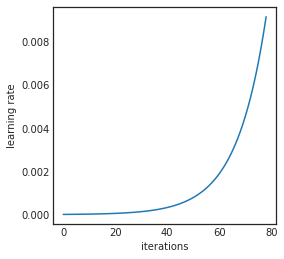

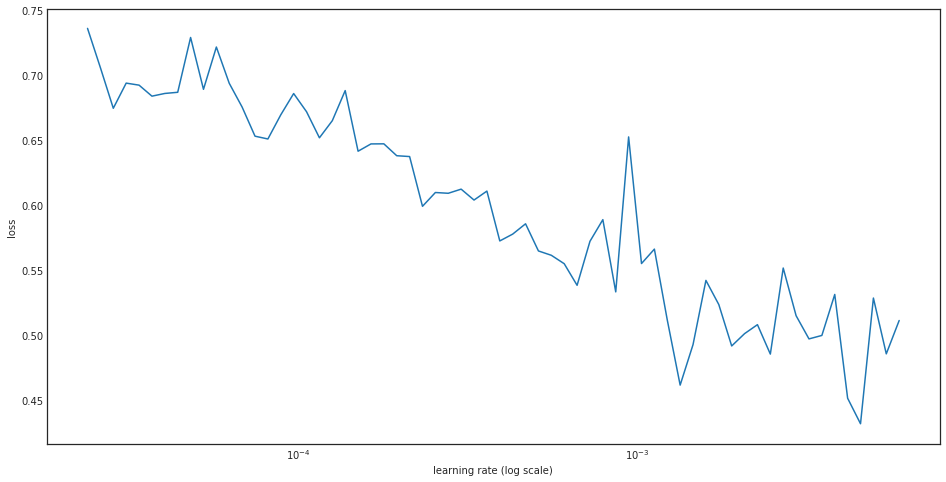

______________________________________



In [4]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-5,1e-2], trainOnWeights=False, verbose=0)

In [4]:
compileArgs['lr'] = 1e-3

## Train classifier

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.476872446036
2 New best found: 0.43248105133
3 New best found: 0.418957934124
4 New best found: 0.40874756942
5 New best found: 0.393260076264
6 New best found: 0.384763251958
7 New best found: 0.383859302695
10 New best found: 0.376875959358
11 New best found: 0.375374885514
12 New best found: 0.372667387532
13 New best found: 0.371273598003
14 New best found: 0.371042553964
15 New best found: 0.370886642001
22 New best found: 0.369252242539
23 New best found: 0.368882865698
24 New best found: 0.367278482389
26 New best found: 0.364674054589
28 New best found: 0.364644803276
30 New best found: 0.364239800532
31 New best found: 0.364218684662
Early stopping after 41 epochs
Score is: {'loss': 0.36421868466237539, 'AUC': 0.094085886151187736, 'wAUC': 0.070288081646210587}
Fold took 35.220s

Running fold 2 / 10
1 New best found: 0.479258640192
2 New best found: 0.421754049283
3 New best

6 New best found: 0.393874220089
7 New best found: 0.391650710672
10 New best found: 0.3872592974
11 New best found: 0.386485390243
12 New best found: 0.386157630318
13 New best found: 0.382136363578
14 New best found: 0.381337001843
15 New best found: 0.380979738227
21 New best found: 0.380179883313
24 New best found: 0.376818050369
25 New best found: 0.37569402641
27 New best found: 0.375257393261
28 New best found: 0.374501324059
30 New best found: 0.374418695721
31 New best found: 0.374386859243
Early stopping after 41 epochs
Score is: {'loss': 0.37438685924322929, 'AUC': 0.10047501786918134, 'wAUC': 0.074284697437052349}
Fold took 32.988s


______________________________________
Training finished
Cross-validation took 330.874s 


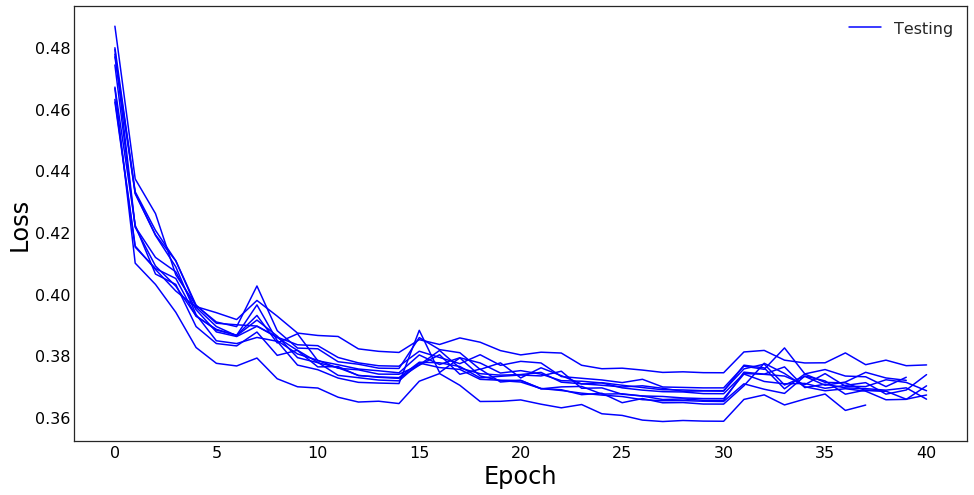

Mean wAUC = 0.0715 +- 0.0007
______________________________________



In [5]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, cosAnnealMult=2, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, verbose=1)

In [ ]:
print 'Training ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData)),
                                                            roc_auc_score(getFeature('targets', trainData), getFeature('pred', trainData), sample_weight=getFeature('weights', trainData)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', testData), getFeature('pred', testData)),
                                                           roc_auc_score(getFeature('targets', testData), getFeature('pred', testData), sample_weight=getFeature('weights', testData)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'gen_sample', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['gen_weight'] = getFeature('weights', datafile, nLoad)
    data['gen_sample'] = getFeature('gen_sample', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
devData = convertToDF(trainData)
valData = convertToDF(testData)

In [ ]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### ROC curve

In [ ]:
rocPlot(inData=[devData, valData],
        params=[{'linestyle':'dashed', 'color':'b'}, {'color':'b'}],
        labels=['Train', 'Test'], weightName='gen_weight')

### MVA distributions

In [ ]:
getClassPredPlot([valData[bkgVal], valData[sigVal]], weightName='gen_weight')

In [ ]:
getSamplePredPlot(valData)

## Save classified data

In [ ]:
name = dirLoc + signal + "_" + channel + "_" + varSet + '_' + classModel + '_classifiedData.csv'
print "Saving data to", name
valData.to_csv(name, columns=['gen_target', 'gen_weight', 'gen_sample', 'pred_class'])

## Save/load

In [ ]:
name = "weights/DNN_" + signal + "_" + channel + "_" + varSet + '_' + classModel
print name

### Save

In [ ]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=1)

### Load

In [ ]:
ensemble, weights, compileArgs, inputPipe, outputPipe = loadEnsemble(name)